This notebook: 
1. loads disp rate maps and residual stds (rmse) for one time period, plots them. 
2. loads avg coh, coh std, amp dispersion, and avg amp files.
3. plot velocity maps masked by threshold values
4. optional: interpolates the masked vel. maps from just "good" or just "bad" data. 
5. calculates and plots skewness and std over a moving window over velocity map.
6. calculates and plots the Guassian-filtered, masked velocity map. 

This notebook was copied and edited on 5-10-23, 6-21-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy import signal
%matplotlib  widget 

Use filt? Or unfilt?

In [2]:
# choose 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

Load dates of SLCs/igrams and set directories.

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
#driver=gdal.GetDriverByName('ISCE')

Define the intervals.

In [4]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(end_indices)
# the last one I just added (4-12-23) as a totally dry period

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
print(str(num_intervals)+' intervals.')

interval 0: 20170510-20181125
interval 1: 20181207-20200412
interval 2: 20200418-20201208
interval 3: 20201214-20220108
interval 4: 20170510-20191220
interval 5: 20170510-20220108
interval 6: 20200412-20210119
7 intervals.


Choose which interval to plot for all the following plots. 

In [5]:
j = 5; i = j

Read in disp rate maps and residual std maps.

In [6]:
# read in disp rate file + rmse file
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_errors = np.ndarray((dy,dx),dtype='float') 
f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None
f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
disp_rates_errors = f1.ReadAsArray()
f1 = None
print('interval '+str(j)+' disp rate map + errors loaded.')

interval 5 disp rate map + errors loaded.


Plot the disp rate map and the map of errors.

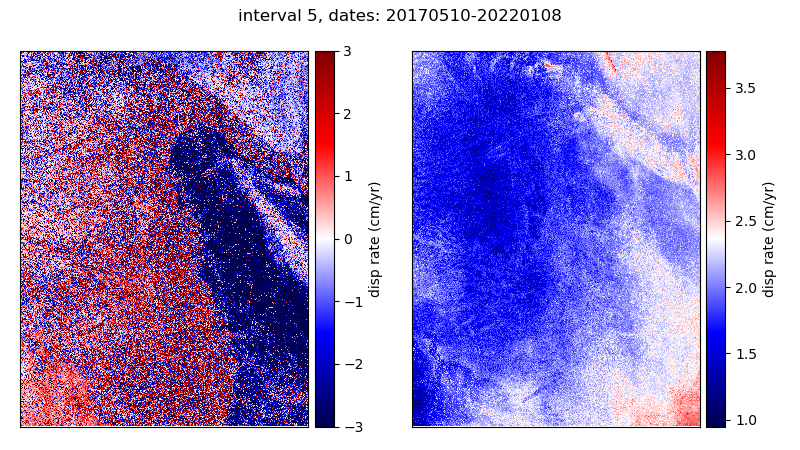

In [7]:
i = j # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(8,4.5),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(disp_rates, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(disp_rates_errors, aspect='auto',\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.suptitle('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

Now load files:
1. avg coherence
2. std of coherence
3. amp dispersion
4. avg amp
5. unwrap errors

In [8]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'coh_avg.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_avg = f1.ReadAsArray(); f1 = None
print('Avg coh values map loaded.')

file_name = 'coh_std.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_std = f1.ReadAsArray(); f1 = None
print('Std of coh map loaded.')

file_name = 'amp_dispersion.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
amp_dispersion = f1.ReadAsArray(); f1 = None
print('Amplitude dispersion for each pixel loaded.')

file_name = 'avg_amp.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
avg_amp = f1.ReadAsArray(); f1 = None
print('Average amp for each pixel loaded.')

file_name = 'unfilt_unwrapped/wrap_err.i1' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
wrap_err = f1.ReadAsArray(); f1 = None
print('wrap errors for each pixel loaded.')

file_name = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/hpcor.r4' 
f1 = gdal.Open(file_name, gdal.GA_ReadOnly)
hp = f1.ReadAsArray(); f1 = None
# cropped area
x1 = 18000; x2 = 14000
y1 = 2100; y2 = 1000
hp_phs = hp[y2:y1,x2:x1]
print('high pass phase for each pixel loaded.')

Avg coh values map loaded.
Std of coh map loaded.
Amplitude dispersion for each pixel loaded.
Average amp for each pixel loaded.
wrap errors for each pixel loaded.
high pass phase for each pixel loaded.


Make a colormap where Nans are different color: try green.

In [9]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


Set threshold values here and do the masking accordingly.

amp disp range: <br>
best   0-0.25 best <br>
worse  0.25-0.4 <br>
<br>
wrap err <br>
best   0-5 <br>
worse  5-15 <br>
<br>
hp phase <br>
best   0.8 and above <br>
worse  0.6-0.8 <br>


In [ ]:
ad_best  = 0.35
ad_ok    = 0.5
we_best  = 5
we_ok    = 10
hp_best  = 0.8
hp_ok    = 0.6

amp_disp_pop1 = np.ma.masked_where(amp_dispersion>ad_best,disp_rates)
amp_disp_pop2 = np.ma.masked_where(amp_dispersion<ad_best,disp_rates); amp_disp_pop2 = np.ma.masked_where(amp_dispersion>ad_ok,amp_disp_pop2)

wrap_err_pop1 = np.ma.masked_where(wrap_err>we_best,disp_rates)
wrap_err_pop2 = np.ma.masked_where(wrap_err<we_best,disp_rates); wrap_err_pop2 = np.ma.masked_where(wrap_err>we_ok,wrap_err_pop2)

hp_phs_pop1 = np.ma.masked_where(hp_phs<hp_best,disp_rates)
hp_phs_pop2 = np.ma.masked_where(hp_phs>hp_best,disp_rates); hp_phs_pop2 = np.ma.masked_where(hp_phs<hp_ok,disp_rates)

Plot the masked versions of the velocity map.

In [ ]:
plt.figure(figsize=(10,15),tight_layout=True)
plt.subplot(3,2,1)
plt.imshow(amp_disp_pop1, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1: Amp Disp <'+str(ad_best))
plt.subplot(3,2,2)
plt.imshow(amp_disp_pop2, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop2: Amp Disp '+str(ad_best)+'-'+str(ad_ok))
plt.subplot(3,2,3)
plt.imshow(wrap_err_pop1, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1: Wrap Error <'+str(we_best))
plt.subplot(3,2,4)
plt.imshow(wrap_err_pop2, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop2: Wrap Error '+str(we_best)+'-'+str(we_ok))
plt.subplot(3,2,5)
plt.imshow(hp_phs_pop1, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1: HP Phase >'+str(hp_best))
plt.subplot(3,2,6)
plt.imshow(hp_phs_pop2, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1: HP Phase '+str(hp_ok)+'-'+str(hp_best))
plt.suptitle('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

Test the method of convolving an array with a Gaussian kernel instead of doing a gaussian_filter. 

In [ ]:
# this is the mask array. Only keeping one point.
dy_test = 100
dx_test = 100
num_pts = 5
test_array = np.zeros((dy_test,dx_test))
# test_array[35,40] = 1.0
# test_array[65,60] = 1.0
# test_array[25,80] = 1.0
# test_array[48,50] = 1.0
indices_x = np.random.randint(0,dx_test,size=num_pts)
indices_y = np.random.randint(0,dy_test,size=num_pts)
test_array[indices_y,indices_x] = 1.0

# this is the test velocity array
# test_vels = np.zeros((dy_test,dx_test))+5
# test_vels[40:60,:] = 8.8
# test_vels[50,50] = 11.1
test_vels = np.random.normal(8.0,3.0,(100,100))
#^ make this all one value with Gaussian noise, std greater or smaller than 1 becuase hard to tell btw std and variance, give more unmasked points 

stdrg_test = 10
stdaz_test = 4
# kernlenrg = 3*stdrg+1
# kernlenaz = 3*stdaz+1

kernlenrg_test = 8*stdrg_test+1
kernlenaz_test = 8*stdaz_test+1

# gaussian filter method
test_gauss_filt = gaussian_filter(test_array,sigma=[stdrg_test,stdaz_test])

# gaussian kernel method
kernrg = signal.gaussian(kernlenrg_test, std=stdrg_test) #.reshape(kernlenrg,1)
kernaz = signal.gaussian(kernlenaz_test, std=stdaz_test) #.reshape(kernlenaz,1)
wind2d = np.outer(kernrg,kernaz)
wind2d = wind2d/np.sum(wind2d)
test_gauss_kern = signal.convolve2d(test_array, wind2d, mode='same') # 'same' means output is same size as first input

#mask_y_test,mask_x_test = np.nonzero(test_array)
#Nans_y_test,Nans_x_test = np.where(test_gauss_kern==0)      # find where the filtered mask didn't reach (which pix are still 0)
#^skip these
# use [test_gauss_kern==0] 


vels_masked_test = np.zeros((dy_test,dx_test))             # initialize array of zeros that's the same size as input for the velocities
vels_masked_test[np.nonzero(test_array)] = test_vels[np.nonzero(test_array)]      # put in the "good" disp rates into the masked vels array.
# use this type of indexing instead of the one I was using before^

vels_filt_test = signal.convolve2d(vels_masked_test, wind2d, mode='same')  # filter the vels_masked 

# divide the two
ab_test_Nans = vels_filt_test / test_gauss_kern                  # this puts Nans where 0/0
#ab_test[Nans_y_test,Nans_x_test] = np.nan                  # put Nans where the smoothed values didn't reach. It did this automatically
ab_test = np.copy(ab_test_Nans)
ab_test[test_gauss_kern==0] = 0.0                      # this is where it gave 0/0=Nan, put zeros back in. 

# calculate the variance of the velocity 
#residuals_test_Nans = test_vels-ab_test_Nans                       # removed on avg the mean, this is (value-mean) 
residuals_test_Nans = np.zeros((dy_test,dx_test))*np.nan
residuals_test_Nans[np.nonzero(test_array)] = test_vels[np.nonzero(test_array)] - ab_test[np.nonzero(test_array)]
# above is residuals of filtered vels for non-masked pixels, minus original vels for non-masked pixels 

residuals2_test_Nans = np.square(residuals_test_Nans)                   # (value-mean)^2
residuals2_test = np.zeros((dy_test,dx_test))
residuals2_test[np.nonzero(test_array)] = residuals2_test_Nans[np.nonzero(test_array)]
#print(residuals2_test[mask_y_test,mask_x_test])

#-------------------------------------------working up until here-------------------------------------------


# variance of velocities 
var_filt_test = signal.convolve2d(residuals2_test, wind2d, mode='same')    # avg of the (value-mean)^2

var_ab_test = var_filt_test/test_gauss_kern                    # divide by mask to not create edge effects that drop off to zero 
#var_ab_test[Nans_y_test,Nans_x_test] = np.nan              # put Nans where the smoothed values didn't reach.

var_multiplier_test = signal.convolve2d(test_array,wind2d**2,mode='same')

# variance of means of velocity 
#var_mean_ab = var_ab/mask_num_pix           # get the variance of the means, dividing by the num of pixels 
var_mean_ab_test = var_ab_test*var_multiplier_test
var_mean_ab_test[test_gauss_kern==0] = np.nan         # put Nans back in where no values should be. 


plt.figure(figsize=(8,16),tight_layout=True)
plt.subplot(6,3,1)
plt.imshow(test_vels,cmap='viridis',interpolation='none',vmin=5,vmax=11.5)
plt.title('test velocities'); plt.colorbar()
plt.subplot(6,3,2)
plt.imshow(test_array,cmap='gray',interpolation='none')
plt.title('test mask array'); plt.colorbar()
plt.subplot(6,3,3)
plt.imshow(test_gauss_kern,cmap='gray',interpolation='none')
plt.title('gaussian kernel convolved'); plt.colorbar()
plt.subplot(6,3,4)
plt.imshow(vels_filt_test,cmap='viridis',interpolation='none')
plt.title('filt vels test'); plt.colorbar()
plt.subplot(6,3,5)
plt.imshow(ab_test_Nans,cmap='viridis',interpolation='none',vmin=5,vmax=11.5)
plt.title('ab test w Nans'); plt.colorbar()
plt.subplot(6,3,6)
plt.imshow(residuals_test_Nans,cmap='viridis',interpolation='none')
plt.title('residuals test w Nans'); plt.colorbar()
plt.subplot(6,3,7)
plt.imshow(residuals2_test_Nans,cmap='viridis',interpolation='none')
plt.title('residuals^2 test w Nans'); plt.colorbar()
plt.subplot(6,3,8)
plt.imshow(residuals2_test,cmap='viridis',interpolation='none')
plt.title('residuals^2 test\nNans -> 0'); plt.colorbar()
plt.subplot(6,3,9)
plt.imshow(var_filt_test,cmap='viridis',interpolation='none')
plt.title('var filt test'); plt.colorbar()

plt.subplot(6,3,10)
plt.imshow(var_ab_test,cmap='viridis',interpolation='none')
plt.title('var ab test'); plt.colorbar()
plt.subplot(6,3,11)
plt.imshow(var_multiplier_test,cmap='viridis',interpolation='none')
plt.title('var multiplier test'); plt.colorbar()

# plt.imshow(var_ab_test,cmap='viridis')
# plt.title('var ab test'); plt.colorbar()
plt.subplot(6,3,12)
plt.imshow(var_mean_ab_test,cmap='viridis',interpolation='none')
plt.title('var mean ab test'); plt.colorbar()
plt.show()

# plt.figure(figsize=(4,4),tight_layout=True)
# plt.imshow(test_gauss_kern-test_gauss_filt,cmap='gray')
# plt.title('gaussian kernel convolved-filt'); plt.colorbar()
# plt.show()

Now define a function to do all the steps.

In [10]:
# convolve a gaussian kernel instead of using gaussian_filter 
def mask_smooth(masked_array,disp_rates,dy,dx):
    #mask_y,mask_x = np.nonzero(masked_array)    # find pix where values haven't been masked
    mask = np.zeros((dy,dx))                    # initialize an array of zeros that's the same size as input for the mask
    mask[np.nonzero(masked_array)] = 1.0                   # put 1's in the spots that had real values 
    #alooks = 4                                  # amount to filter in the azimuth/y direction
    alooks = 8
    #rlooks = 20                                 # amount to filter in the range/x direction
    rlooks = 40 # TRY THIS 
    
    # create Gaussian kernel with proper size
    stdrg = alooks # range, usually rlooks
    stdaz = rlooks # azimuth, usually alooks 
    kernlenrg = 8*stdrg+1 # can try this as 2 
    kernlenaz = 8*stdaz+1
    kernrg = signal.gaussian(kernlenrg, std=stdrg) #.reshape(kernlenrg,1)
    kernaz = signal.gaussian(kernlenaz, std=stdaz) #.reshape(kernlenaz,1)
    wind = np.outer(kernrg,kernaz)
    wind = wind/np.sum(wind)

    print('kernel created.')
    
    mask_filt = signal.convolve2d(mask, wind, mode='same')  # filter the mask to smear it out   
    
    print('kernel convolved with mask.')
    
    # Nans_y,Nans_x = np.where(mask_filt==0)      # find where the filtered mask didn't reach (which pix are still 0)
    vels_masked = np.zeros((dy,dx))             # initialize array of zeros that's the same size as input for the velocities
    vels_masked[np.nonzero(masked_array)] = disp_rates[np.nonzero(masked_array)]      # put in the "good" disp rates into the masked vels array.
    vels_filt = signal.convolve2d(vels_masked, wind, mode='same')  # filter the vels_masked 
    
    print('kernel convolved with masked velocities.')    
    
    # divide the two
    ab_Nans = vels_filt / mask_filt     # start with an array that will have some Nans in it. 
    ab = np.copy(ab_Nans)               # make a copy of it to put zeros back in for the Nans.
    ab[mask_filt==0] = 0.0             # this is where it gave 0/0=Nan, put zeros back in. 
    
    print('convolved velocities divided by convolved mask.')
    
    # calculate the variance of the velocity 
    #residuals_Nans = masked_array-ab                   # removed on avg the mean, this is (value-mean) 
    residuals_Nans = np.zeros((dy,dx))*np.nan           # start with array of Nans
    residuals_Nans[np.nonzero(masked_array)] = disp_rates[np.nonzero(masked_array)]-ab[np.nonzero(masked_array)]     
    # above is residuals of filtered vels for non-masked pixels, minus original vels for non-masked pixels
    residuals2_Nans = np.square(residuals_Nans)                     # (value-mean)^2
    residuals2 = np.zeros((dy,dx))                                  # start with array of zeros
    residuals2[np.nonzero(masked_array)] = residuals2_Nans[np.nonzero(masked_array)]      # picking out values from mask where residuals are meaningful 

    print('residuals and residuals^2 calculated between input vels and smoothed vels.')
    
    var_filt = signal.convolve2d(residuals2, wind, mode='same')    # avg of the (value-mean)^2

    print('residuals convolved with window to get smoothed variances.')

    var_multiplier = signal.convolve2d(mask,wind**2,mode='same')

    print('multiplier calcualted to get variances of vel means')

    # variance of velocities 
    #mask_num_pix = mask_filt * (alooks*rlooks) - 1  # this gives you number of pixels - 1, weighted by Gaussian filter 
    var_ab = var_filt/mask_filt                 # divide by mask to not create edge effects that drop off to zero 
    var_ab[mask_filt==0] = np.nan              # put Nans where the smoothed values didn't reach.

    print('smoothed variances divided by smoothed mask.')

    # variance of means of velocity         
    var_mean_ab = var_ab*var_multiplier         # get the variance of the means, dividing by the num of pixels 
    var_mean_ab[mask_filt==0] = np.nan         # put Nans back in where no values should be. 

    print('variances of mean vels calculated.')

    return mask_filt, ab_Nans, var_ab, var_mean_ab

This is the old version. It uses gaussian_filter instead of convolving a Gaussian kernel with the data.

In [ ]:
def mask_smooth2(masked_array,disp_rates,dy,dx):
    mask_y,mask_x = np.nonzero(masked_array)    # find pix where values haven't been masked
    mask = np.zeros((dy,dx))                    # initialize an array of zeros that's the same size as input for the mask
    mask[mask_y,mask_x] = 1.0                   # put 1's in the spots that had real values 
    #alooks = 4                                 # amount to filter in the azimuth/y direction
    alooks = 8
    #rlooks = 20                                # amount to filter in the range/x direction
    rlooks = 40 # TRY THIS 
    mask_filt = gaussian_filter(mask,sigma=[alooks,rlooks])     # filter the mask to smear it out
    Nans_y,Nans_x = np.where(mask_filt==0)      # find where the filtered mask didn't reach (which pix are still 0)
    vels_masked = np.zeros((dy,dx))             # initialize array of zeros that's the same size as input for the velocities
    vels_masked[mask_y,mask_x] = disp_rates[mask_y,mask_x]      # put in the "good" disp rates into the masked vels array.
    vels_filt = gaussian_filter(vels_masked,sigma=[alooks,rlooks])  # filter the vels_masked 
    # divide the two
    ab = vels_filt / mask_filt    
    #ab[mask_y,mask_x] = disp_rates[mask_y,mask_x]   # put back in the good values. OPTIONAL
    ab[Nans_y,Nans_x] = np.nan                  # put Nans where the smoothed values didn't reach.

    # calculate the std of the mean velocity 
    #residuals = masked_array-ab                 # removed on avg the mean, this is (value-mean) 
    residuals = disp_rates-ab #??????
    residuals2 = np.square(residuals)                   # (value-mean)^2
    var_filt = gaussian_filter(residuals2,sigma=[alooks,rlooks])    # avg of the (value-mean)^2
    
    mask_num_pix = mask_filt * (alooks*rlooks) - 1  # this gives you number of pixels - 1, weighted by Gaussian filter 
    
    var_ab = var_filt/mask_num_pix                 # divide by mask to not create edge effects that drop off to zero 
    var_ab[Nans_y,Nans_x] = np.nan              # put Nans where the smoothed values didn't reach.

    var_mean_ab = var_ab/mask_num_pix           # get the variance of the means, dividing by the num of pixels 
    var_mean_ab[Nans_y,Nans_x] = np.nan         # put Nans back in where no values should be. 

    return ab, var_ab, var_mean_ab

In [ ]:
ad_mask_filt, ad_pop1_smooth, ad_var_pop1, ad_var_mean_pop1= mask_smooth(amp_disp_pop1,disp_rates,dy,dx)
# step 2 (first convolution) takes 22 minutes with 80x16 window. 
# up to step 3 takes 44 minutes, so each convolution must take ~22 mins. Four total? took 88 minutes total with 80x16 window 
#    but window was in wrong direction!!

# trying smaller window: 4x20. See how long that takes. 
# it works now!! Had my azimuth and range downlook window dimensions mixed up somehow... ugh.

# now with 8x40 window, it takes ~20ish minutes total.


In [ ]:
ad_pop1_smooth_2, ad_var_pop1_2, ad_var_mean_pop1_2= mask_smooth2(amp_disp_pop1,disp_rates,dy,dx)

In [ ]:
plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(ad_pop1_smooth,cmap=seismic2,aspect='auto',interpolation='none',vmin=-3,vmax=3); plt.xlim([dx,0])
plt.title('gauss kernel method'); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(ad_pop1_smooth_2,cmap=seismic2,aspect='auto',interpolation='none',vmin=-3,vmax=3); plt.xlim([dx,0])
plt.title('gauss filter method'); plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(ad_var_pop1,cmap=seismic2,aspect='auto',interpolation='none',vmin=0,vmax=2)
plt.xlim([dx,0])
plt.title('variance of vels')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(ad_var_mean_pop1,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('variance of mean vels')
plt.colorbar()
plt.suptitle('gauss filter method')
plt.show()

In [ ]:
# run the function for all the masked maps
ad_pop1_mask_filt, ad_pop1_smooth, ad_var_pop1, ad_var_mean_pop1 = mask_smooth(amp_disp_pop1,disp_rates,dy,dx)
ad_pop2_mask_filt, ad_pop2_smooth, ad_var_pop2, ad_var_mean_pop2 = mask_smooth(amp_disp_pop2,disp_rates,dy,dx)
we_pop1_mask_filt, we_pop1_smooth, we_var_pop1, we_var_mean_pop1 = mask_smooth(wrap_err_pop1,disp_rates,dy,dx)
we_pop2_mask_filt, we_pop2_smooth, we_var_pop2, we_var_mean_pop2 = mask_smooth(wrap_err_pop2,disp_rates,dy,dx)
hp_pop1_mask_filt, hp_pop1_smooth, hp_var_pop1, hp_var_mean_pop1 = mask_smooth(hp_phs_pop1,disp_rates,dy,dx)
hp_pop2_mask_filt, hp_pop2_smooth, hp_var_pop2, hp_var_mean_pop2 = mask_smooth(hp_phs_pop2,disp_rates,dy,dx)

Now plot them all together.

In [ ]:
plt.figure(figsize=(12,12),tight_layout=True)
# Amp disp 
plt.subplot(3,3,1)
plt.imshow(ad_pop1_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1: Amp Disp <'+str(ad_best))
plt.subplot(3,3,2)
plt.imshow(ad_pop2_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop2: Amp Disp '+str(ad_best)+'-'+str(ad_ok))
plt.subplot(3,3,3)
plt.imshow(ad_pop1_smooth-ad_pop2_smooth, aspect='auto',vmin=-0.5,vmax=0.5,interpolation='nearest') 
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1-Pop2')

# Wrap Error 
plt.subplot(3,3,4)
plt.imshow(we_pop1_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1: Wrap Error <'+str(we_best))
plt.subplot(3,3,5)
plt.imshow(we_pop2_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop2: Wrap Error '+str(we_best)+'-'+str(we_ok))
plt.subplot(3,3,6)
plt.imshow(we_pop1_smooth-we_pop2_smooth, aspect='auto',vmin=-0.5,vmax=0.5,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1-Pop2')

# HP Phase
plt.subplot(3,3,7)
plt.imshow(hp_pop1_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1: HP Phase >'+str(hp_best))
plt.subplot(3,3,8)
plt.imshow(hp_pop2_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1: HP Phase '+str(hp_ok)+'-'+str(hp_best))
plt.subplot(3,3,9)
plt.imshow(hp_pop1_smooth-hp_pop2_smooth, aspect='auto',vmin=-0.5,vmax=0.5,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1-Pop2')

plt.suptitle('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

Smooth out the difference plots and plot them. 

In [ ]:
ad_diffs = ad_pop1_smooth-ad_pop2_smooth
we_diffs = we_pop1_smooth-we_pop2_smooth
hp_diffs = hp_pop1_smooth-hp_pop2_smooth

# filter size
alooks = 8                             
rlooks = 40

ad_diffs_smooth = gaussian_filter(ad_diffs,sigma=[alooks/2,rlooks/2])
we_diffs_smooth = gaussian_filter(we_diffs,sigma=[alooks/2,rlooks/2])
hp_diffs_smooth = gaussian_filter(hp_diffs,sigma=[alooks/2,rlooks/2])

In [ ]:
plt.figure(figsize=(12,4),tight_layout=True)
# Amp disp 
plt.subplot(1,3,1)
plt.imshow(ad_diffs_smooth, aspect='auto', vmin=-1.0,vmax=1.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Amp Disp Diffs')
plt.subplot(1,3,2)
plt.imshow(we_diffs_smooth, aspect='auto', vmin=-1.0,vmax=1.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Wrap Errors Diffs')
plt.subplot(1,3,3)
plt.imshow(hp_diffs_smooth, aspect='auto',vmin=-1,vmax=1,interpolation='nearest') 
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('HP Phase Diffs')
plt.show()

Combined criteria! 

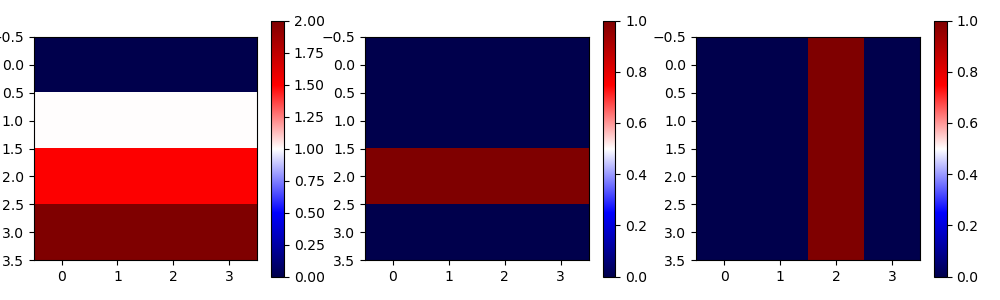

[[False False False False]
 [False False False False]
 [ True  True  True  True]
 [False False False False]]
[[False False  True False]
 [False False  True False]
 [False False  True False]
 [False False  True False]]
[[False False False False]
 [False False False False]
 [False False  True False]
 [False False False False]]


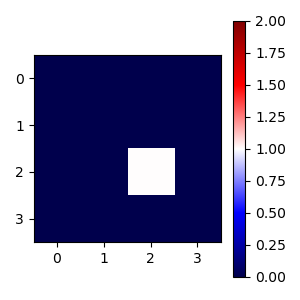

In [11]:
select_array = np.zeros((4,4))
select_array[1,:] = 1.0; select_array[2,:] = 1.5; select_array[3,:] = 2.0
test = np.zeros((4,4))
test[2,:] = 1.0
test2 = np.zeros((4,4))
test2[:,2] = 1.0
plt.figure(figsize=(10,3),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(select_array); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(test); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(test2); plt.colorbar()
plt.show()
test_mask = (test > 0.5) #and (test2 > 0.5)
test2_mask = (test2 > 0.5)
print(test_mask)
print(test2_mask)

test3 = test_mask * test2_mask
print(test3)
plt.figure(figsize=(3,3),tight_layout=True)
plt.imshow(test3,vmin=0,vmax=2); plt.colorbar()
plt.show()


In [12]:
#   for reference: 
# ad_best  = 0.35
# ad_ok    = 0.5
# we_best  = 5
# we_ok    = 10
# hp_best  = 0.8
# hp_ok    = 0.6

# POPULATION 1
# boolean arrays 
ad_pop1_mask = (amp_dispersion<ad_best) 
we_pop1_mask = (wrap_err<we_best) 
hp_pop1_mask = (hp_phs>hp_best)
# by adding, essentially does "or" statement for all conditions. Still boolean array.
pop1_combo_mask = ad_pop1_mask + we_pop1_mask + hp_pop1_mask
# now mask disp rates based on where mask is True/False
pop1_combo = np.ma.masked_where(pop1_combo_mask==False,disp_rates)

# POPULATION 2
ad1_pop2_mask = (amp_dispersion>ad_best) 
ad2_pop2_mask = (amp_dispersion<ad_ok) 
we1_pop2_mask = (wrap_err>we_best) 
we2_pop2_mask = (wrap_err<we_ok) 
hp1_pop2_mask = (hp_phs<hp_best)
hp2_pop2_mask = (hp_phs>hp_ok)
pop2_last_mask = (pop1_combo_mask==False)
# by adding, essentially does "or" statement for all conditions. Still boolean array.
pop2_combo_mask = (ad1_pop2_mask*ad2_pop2_mask) + (we1_pop2_mask*we2_pop2_mask) + (hp1_pop2_mask*hp2_pop2_mask)
pop2_combo_mask = pop2_combo_mask * pop2_last_mask 
# now mask disp rates based where mask is False
pop2_combo = np.ma.masked_where(pop2_combo_mask==False,disp_rates)

# plot POP 1
plt.figure(figsize=(12,8),tight_layout=True)
plt.subplot(2,3,1)
plt.imshow(ad_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(we_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(hp_pop1_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(pop1_combo_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(pop1_combo,aspect='auto',interpolation='none'); plt.colorbar()
plt.show()

# plot POP 2
plt.figure(figsize=(12,8),tight_layout=True)
plt.subplot(2,3,1)
plt.imshow(ad1_pop2_mask*ad2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(we1_pop2_mask*we2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(hp1_pop2_mask*hp2_pop2_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(pop2_last_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(pop2_combo_mask,aspect='auto',interpolation='none'); plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(pop2_combo,aspect='auto',interpolation='none'); plt.colorbar()
plt.show()

NameError: name 'ad_best' is not defined

In [13]:
neither_pop12 = (pop1_combo_mask + pop2_combo_mask)

plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(pop1_combo_mask,aspect='auto',interpolation='none')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1')
plt.subplot(1,3,2)
plt.imshow(pop2_combo_mask, aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2')
plt.subplot(1,3,3)
plt.imshow(neither_pop12, aspect='auto',interpolation='nearest') 
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('black = neither pop1 or pop2')
plt.show()

NameError: name 'pop1_combo_mask' is not defined

Save the pop1 and pop2 masks as files/arrays of 0's and 1's for future use.

In [ ]:
to_save_pop1 = np.zeros((dy,dx))
to_save_pop1[pop1_combo_mask.nonzero()] = 1.0
to_save_pop2 = np.zeros((dy,dx))
to_save_pop2[pop2_combo_mask.nonzero()] = 1.0

plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(to_save_pop1,aspect='auto',interpolation='none')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1')
plt.subplot(1,2,2)
plt.imshow(to_save_pop2, aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2')
plt.show()

# # now save them. Only needed to do this once.
# driver=gdal.GetDriverByName('ISCE')
# saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/'
# file1 = 'pop1_mask.r4'
# colds = driver.Create(saveDir+file1,dx,dy,1,gdal.GDT_Float32)
# colds.GetRasterBand(1).WriteArray(to_save_pop1)
# colds=None
# file2 = 'pop2_mask.r4'
# colds = driver.Create(saveDir+file2,dx,dy,1,gdal.GDT_Float32)
# colds.GetRasterBand(1).WriteArray(to_save_pop2)
# colds=None
# print('pop1 and pop2 masks saved.')

Mask the loaded velocity map based on pop1 and pop2. Don't display pixels from neither pop. 

In [ ]:
# mask vel map 
vel_map_masked = np.ma.masked_where(neither_pop12==0,disp_rates)

# filter size
alooks = 8                             
rlooks = 40

# now try smoothing out the masked version, then re-input the true values back in. 
vel_map_masked_smoothed = gaussian_filter(vel_map_masked,sigma=[alooks,rlooks])
vel_map_masked_smoothed[np.nonzero(vel_map_masked)] = vel_map_masked[np.nonzero(vel_map_masked)]

i = j # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(10,5),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(vel_map_masked, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('Nans displayed')
plt.subplot(1,2,2)
plt.imshow(vel_map_masked_smoothed, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('Nans smoothed out')
plt.show()

Do the smoothing of pop1 and pop2 masked arrays so I can difference them.

In [ ]:
# run the function for all the masked maps
pop1_mask_filt, pop1_smooth, var_pop1, var_mean_pop1 = mask_smooth(pop1_combo,disp_rates,dy,dx)
pop2_mask_filt, pop2_smooth, var_pop2, var_mean_pop2 = mask_smooth(pop2_combo,disp_rates,dy,dx)

Plot them and the difference between them. 

In [ ]:
plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(pop1_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1')
plt.subplot(1,3,2)
plt.imshow(pop2_smooth, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2')
plt.subplot(1,3,3)
plt.imshow(pop1_smooth-pop2_smooth, aspect='auto',vmin=-1,vmax=1,interpolation='nearest') 
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1-Pop2')
plt.show()

Plot variances of velocities and variances of velocity means for pop1 and po2.

In [ ]:
plt.figure(figsize=(10,8),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(var_pop1,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('pop1, var of vels')
plt.colorbar(label='variance (cm/yr)')
plt.subplot(2,2,2)
plt.imshow(var_pop2,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('pop2, var of vels')
plt.colorbar(label='variance (cm/yr)')
plt.subplot(2,2,3)
plt.imshow(var_mean_pop1,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('pop1, var of vel mean')
plt.colorbar(label='variance (cm/yr)')
plt.subplot(2,2,4)
plt.imshow(var_mean_pop2,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('pop2, var of vel mean')
plt.colorbar(label='variance (cm/yr)')
plt.show()

Plot Pop1-Pop2 vs. cumulative TPC. See if linear or anything other than blob.

In [14]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'
file_name = 'TPC_avgs.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
avg_TPCs = f1.ReadAsArray()
f1 = None
print('Avg TPC values map loaded.')

Avg TPC values map loaded.


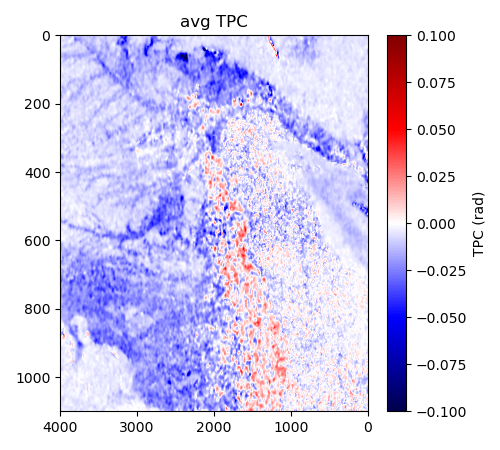

In [20]:
plt.figure(figsize=(5,4.5),tight_layout=True)
plt.imshow(avg_TPCs,aspect='auto',vmin=-0.1,vmax=0.1)
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('avg TPC')
plt.colorbar(label='TPC (rad)')
plt.show()

In [21]:
print(-0.006086481*210)

-1.27816101


In [15]:
# average mean TPC over box 1
box1x = [3500, 4000];  box1dx = box1x[1]-box1x[0]
box1y = [425, 525];   box1dy = box1y[1]-box1y[0]

print(np.mean(avg_TPCs[box1y[0]:box1y[1],box1x[0]:box1x[1]]))

-0.006086481


In [ ]:
import matplotlib.colors as mcolors
plt.figure(figsize=(6,4),tight_layout=True)
plt.hist2d((pop1_smooth-pop2_smooth).flatten(),avg_TPCs.flatten(),bins=200,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
plt.colorbar(label='pixel density'); plt.set_cmap('plasma') # plasma is original 
plt.ylim([-0.05,0.05])
plt.xlim([-1,1])
plt.ylabel('Avg TPC (rad)')
plt.xlabel('Pop1-Pop2 velocities (cm/yr)')
plt.show()

In [ ]:
plt.figure(figsize=(6,4),tight_layout=True)
pop_diffs = pop1_smooth-pop2_smooth
plt.hist((pop_diffs).flatten(),bins=200) 
plt.xlim([-1,1])
plt.ylabel('Number of pixels')
plt.xlabel('Pop1-Pop2 velocities (cm/yr)')
plt.show()

Maybe try separating LS vs non-LS pixels and see why that explains the two-humped histogram of rate differences.

In [ ]:
load = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/LS_mask.r4'
f1 = gdal.Open(load, gdal.GA_ReadOnly)
LS_mask = f1.ReadAsArray()
f1 = None
print('LS mask loaded.')

load = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/mtns_mask.r4'
f1 = gdal.Open(load, gdal.GA_ReadOnly)
mtns_mask = f1.ReadAsArray()
f1 = None
print('Mountains mask loaded.')

In [ ]:
# plot LS pixels and non-LS/mtns pixels and their rate diffs btw populations 1,2
LS_diffs = np.zeros((dy,dx))*np.nan
LS_diffs[LS_mask.nonzero()] = pop_diffs[LS_mask.nonzero()]
# desert_diffs = np.zeros((dy,dx))*np.nan
# desert_diffs[LS_mask==0] = pop_diffs[LS_mask==0]
#desert_diffs[mtns_mask==0] = pop_diffs[mtns_mask==0]
desert_diffs = np.copy(pop_diffs)
desert_diffs[LS_mask==1] = np.nan
desert_diffs[mtns_mask==1] = np.nan

plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(LS_diffs,cmap=seismic2,aspect='auto',vmin=-1,vmax=1)
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.xlim([dx,0])
plt.title('Laguna Salada rate diffs')
plt.subplot(1,2,2)
plt.imshow(desert_diffs,cmap=seismic2,aspect='auto',vmin=-1,vmax=1)
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.title('Desert (not LS or mtns) rate diffs')
plt.xlim([dx,0])
plt.show()

Plot histograms of rate diffs in and out of LS.

In [ ]:
plt.figure(figsize=(6,4),tight_layout=True)
LS_median = np.nanmedian((LS_diffs).flatten())
plt.hist((LS_diffs).flatten(),bins=200,label='LS',alpha=0.7,color='tab:blue') 
non_LS_median = np.nanmedian((desert_diffs).flatten())
plt.hist((desert_diffs).flatten(),bins=200,label='desert',alpha=0.7,color='tab:orange') 
plt.legend()
plt.xlim([-1,1])
ymin,ymax = plt.gca().get_ylim()
plt.vlines(LS_median,ymin,ymax,color='tab:blue')
plt.vlines(non_LS_median,ymin,ymax,color='tab:orange')
plt.ylim([ymin,ymax])
plt.ylabel('Number of pixels')
plt.xlabel('Pop1-Pop2 velocities (cm/yr)')
plt.show()

print(LS_median)
print(non_LS_median)

Combined variances of pop1 and pop2.

In [ ]:
std_mean_vels = np.sqrt(var_mean_pop1+var_mean_pop2)

plt.figure(figsize=(6,6),tight_layout=True)
plt.imshow(std_mean_vels,cmap=seismic2,aspect='auto',interpolation='none')
plt.xlim([dx,0])
plt.title('stds of velocity mean differences,\nboth pop1 and pop2')
plt.colorbar(label='standard deviation (cm/yr)')
plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

In [ ]:
print(np.nanpercentile(std_mean_vels.flatten(),95))
print(np.nanpercentile(std_mean_vels.flatten(),10))

# maybe mask anything with std > 0.03 cm/yr 

Mask the rate diffs map using the combined std criteria.

In [ ]:
# started with 0.03, tried 0.025 which might be ok too.
diffs_masked = np.ma.masked_where(std_mean_vels>0.03,pop_diffs)

plt.figure(figsize=(6,6),tight_layout=True)
plt.imshow(diffs_masked,cmap=seismic2,aspect='auto',interpolation='none',vmin=-1,vmax=1)
plt.xlim([dx,0])
plt.title('pop1-pop2, masked by stds')
plt.colorbar(label='rate difference (cm/yr)')
plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.show()

Everything below here was trying to figure out the variance of the velocities/mean velocity without incorporating the gaussian_kernel code into the function. It accounts for the variance being divided by N-1 and where we will run into issues with /0 -> Nan. I don't think I need this stuff any more though.

***
***

Calculate the number of pixels in each window for each population. 

In [ ]:
# initialize array of Nans for each map.
num_pix_pop1 = np.zeros((dy,dx))*np.nan
num_pix_pop2 = np.zeros((dy,dx))*np.nan

# moving window size. Same as filter size from mask_smooth function.
#alooks = 4                                  # amount to filter in the azimuth/y direction
alooks = 16 # TRY THIS
ylooks = int(alooks/2)
#rlooks = 20                                 # amount to filter in the range/x direction
rlooks = 80                              
xlooks = int(rlooks/2)

# loop through pixels 
for y in range(dy):     #dy
    for x in range(dx): #dx
        # only if not an edge pixel
        if y-ylooks >= 0 and y+ylooks < dy and x-xlooks >= 0 and x+xlooks < dx:
            num_pix_pop1[y,x] = np.sum(pop1_combo_mask[y-ylooks:y+ylooks,x-xlooks:x+xlooks]) # pop1_combo_mask is 1's and 0's so it will add up how many pixels are in pop1 in that window.
            num_pix_pop2[y,x] = np.sum(pop2_combo_mask[y-ylooks:y+ylooks,x-xlooks:x+xlooks])
pix_density_pop1 = num_pix_pop1/(alooks*rlooks)
pix_density_pop2 = num_pix_pop2/(alooks*rlooks)

In [ ]:
gray2 = plt.cm.get_cmap("gray").copy()
gray2.set_bad(color='green')
print('colormap made where NANs will be green.')

In [ ]:
plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(pix_density_pop1*100, aspect='auto',interpolation='nearest',vmin=0.00000001,vmax=100)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1, pixel density')
plt.subplot(1,2,2)
plt.imshow(pix_density_pop2*100, aspect='auto', interpolation='nearest',vmin=0.00000001,vmax=100)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2, pixel density')
plt.show()

In [ ]:
plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(pop1_mask_filt*100, aspect='auto',interpolation='nearest',vmin=0,vmax=100)
plt.colorbar(orientation='vertical',pad=0.02,label='weighted pix density (~%)')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
# plt.title('Pop 1 mask filt')
plt.title('Pop 1 pixel density')
plt.subplot(1,2,2)
plt.imshow(pop2_mask_filt*100, aspect='auto', interpolation='nearest',vmin=0,vmax=100)
plt.colorbar(orientation='vertical',pad=0.02,label='weighted pix density (~%)')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
#plt.title('Pop 2 mask filt')
plt.title('Pop 2 pixel density')
plt.show()

In [ ]:
plt.figure(figsize=(8,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(pix_density_pop1/pop1_mask_filt, aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='weighted pix density')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('pix density/Pop 1 mask filt')
plt.subplot(1,2,2)
plt.imshow(pix_density_pop2/pop2_mask_filt, aspect='auto', interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='weighted pix density')
plt.set_cmap(gray2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('pix density/Pop 2 mask filt')
plt.show()

^ The average of those being ~1 means that mask_smooth number corresponds to the pixel density by ~1:1. So if mask_smooth is 0.1, that corresponds to about 10% pixel density in the window. Start with a cutoff like that. 

In [ ]:
print(np.nanpercentile(pop1_mask_filt.flatten(),90))
print(np.nanpercentile(pop1_mask_filt.flatten(),20))

print(np.nanpercentile(pop2_mask_filt.flatten(),90))
print(np.nanpercentile(pop2_mask_filt.flatten(),20))

# maybe mask anything with std > 0.03 cm/yr 

In [ ]:
viridis2 = plt.cm.get_cmap("viridis").copy()
viridis2.set_under(color='red')

plt.figure(figsize=(8,8),tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(num_pix_pop1, aspect='auto',interpolation='nearest',vmin=0,vmax=alooks*rlooks)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(viridis2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1, Num pix in window')
plt.subplot(2,2,2)
plt.imshow(num_pix_pop2, aspect='auto', interpolation='nearest',vmin=0,vmax=alooks*rlooks)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(viridis2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2, Num pix in window')
plt.subplot(2,2,3)
plt.imshow(num_pix_pop1-1, aspect='auto', interpolation='nearest',vmin=0,vmax=15)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(viridis2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1, Num pix in window - 1')
plt.subplot(2,2,4)
plt.imshow(num_pix_pop2-1, aspect='auto', interpolation='nearest',vmin=0,vmax=15)
plt.colorbar(orientation='vertical',pad=0.02,label='pix density (%)')
plt.set_cmap(viridis2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2, Num pix in window - 1')
plt.show()

print(min((num_pix_pop1-1).flatten()))
print(min((num_pix_pop2-1).flatten()))

Now plot the smoothed vel rate maps for pop1 and pop2 and their differences, masked by 2 things: not enough pixel density (~10%?) and too high std of combined velocity means.

In [ ]:
# mask 
pop1_smooth_masked = np.copy(pop1_smooth)
pop2_smooth_masked = np.copy(pop2_smooth)
diffs_masked = pop1_smooth - pop2_smooth
# where combined std is too high
pop1_smooth_masked[std_mean_vels>0.03] = np.nan
pop2_smooth_masked[std_mean_vels>0.03] = np.nan
diffs_masked[std_mean_vels>0.03] = np.nan
# where not enough pixel density 
pix_density_threshold = 0.05
pop1_smooth_masked[pop1_mask_filt<pix_density_threshold] = np.nan
pop1_smooth_masked[pop2_mask_filt<pix_density_threshold] = np.nan
pop2_smooth_masked[pop1_mask_filt<pix_density_threshold] = np.nan
pop2_smooth_masked[pop2_mask_filt<pix_density_threshold] = np.nan
diffs_masked[pop1_mask_filt<pix_density_threshold] = np.nan
diffs_masked[pop2_mask_filt<pix_density_threshold] = np.nan

plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(pop1_smooth_masked, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 1')
plt.subplot(1,3,2)
plt.imshow(pop2_smooth_masked, aspect='auto', vmin=-3.0,vmax=3.0,interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop 2')
plt.subplot(1,3,3)
plt.imshow(diffs_masked, aspect='auto',vmin=-1,vmax=1,interpolation='nearest') 
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap(seismic2)
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
plt.title('Pop1-Pop2')
plt.show()

In [ ]:
# plot LS pixels and desert pixels and their rate diffs btw populations 1,2
# EXCLUDE MASKED PIXELS LIKE ABOVE
LS_diffs_2 = np.zeros((dy,dx))*np.nan
LS_diffs_2[LS_mask.nonzero()] = diffs_masked[LS_mask.nonzero()]

desert_diffs_2 = np.copy(diffs_masked)
desert_diffs_2[LS_mask==1] = np.nan
desert_diffs_2[mtns_mask==1] = np.nan

mtns_diffs_2 = np.zeros((dy,dx))*np.nan
mtns_diffs_2[mtns_mask.nonzero()] = diffs_masked[mtns_mask.nonzero()]

# hist ignores nans which is what we want.
bins = np.linspace(-1,1,200)
plt.figure(figsize=(6,4),tight_layout=True)
mtns_median_2 = np.nanmedian((mtns_diffs_2).flatten())
plt.hist((mtns_diffs_2).flatten(),bins=bins,label='mountains',alpha=0.7,color='k') 
LS_median_2 = np.nanmedian((LS_diffs_2).flatten())
plt.hist((LS_diffs_2).flatten(),bins=bins,label='LS',alpha=0.7,color='tab:blue') 
desert_median_2 = np.nanmedian((desert_diffs_2).flatten())
plt.hist((desert_diffs_2).flatten(),bins=bins,label='desert',alpha=0.7,color='tab:orange') 

plt.legend()
plt.xlim([-1,1])
ymin,ymax = plt.gca().get_ylim()
plt.vlines(LS_median_2,ymin,ymax,color='tab:blue')
plt.vlines(desert_median_2,ymin,ymax,color='tab:orange')
plt.vlines(mtns_median_2,ymin,ymax,color='k')
plt.ylim([ymin,ymax])
plt.ylabel('Number of pixels')
plt.xlabel('Pop1-Pop2 velocities (cm/yr)')
plt.show()

print(LS_median_2)
print(desert_median_2)
print(mtns_median_2)